"""
# Live-Registry Metadata Version-Diff Model (PyPI + npm, no registry_df)

Goal: compare metadata between **benign vs malicious versions of the same package**,
using *live* metadata from PyPI and npm.

Inputs:
- data/meta/labels_version.csv  (one row per malicious version: ecosystem, package_name, version, is_malicious_any_version)
- data/meta/labels_package.csv  (one row per malicious package)

Outputs:
- data/meta/version_delta_features_live.csv
  Each row is a pair (prev_version → malicious_version) with delta metadata features and label y=1 (malicious).
  Optional: we also add a few benign→benign pairs (y=0) as negative examples.
"""


In [3]:
# Cell 2 – Imports & basic config

from pathlib import Path
import time
import requests
from packaging import version as py_version
import numpy as np
import pandas as pd

pd.set_option("future.no_silent_downcasting", True)

META_DIR = Path("../data/meta")
LABELS_VERSION_PATH = META_DIR / "labels_version.csv"
LABELS_PACKAGE_PATH = META_DIR / "labels_package.csv"

print("META_DIR:", META_DIR.resolve())
print("labels_version:", LABELS_VERSION_PATH.resolve())
print("labels_package:", LABELS_PACKAGE_PATH.resolve())


META_DIR: C:\Users\becai\Desktop\CSI 4900 Jupyter\Jupyter_v2\data\meta
labels_version: C:\Users\becai\Desktop\CSI 4900 Jupyter\Jupyter_v2\data\meta\labels_version.csv
labels_package: C:\Users\becai\Desktop\CSI 4900 Jupyter\Jupyter_v2\data\meta\labels_package.csv


In [4]:
# Cell 3 – Load labels and filter to ecosystems we can hit live (PyPI + npm)

labels_version = pd.read_csv(LABELS_VERSION_PATH)
labels_package = pd.read_csv(LABELS_PACKAGE_PATH)

print("labels_version shape:", labels_version.shape)
print("labels_package shape:", labels_package.shape)

# We only handle these two for now
supported_ecosystems = {"pypi", "npm"}
labels_version_live = labels_version[labels_version["ecosystem"].isin(supported_ecosystems)].copy()

print("labels_version_live shape (pypi + npm):", labels_version_live.shape)
print("By ecosystem:")
print(labels_version_live["ecosystem"].value_counts())
labels_version_live.head()


labels_version shape: (656, 9)
labels_package shape: (8855, 8)
labels_version_live shape (pypi + npm): (656, 9)
By ecosystem:
ecosystem
npm     475
pypi    181
Name: count, dtype: int64


,ecosystem,package_name,version,is_malicious_datadog,is_malicious_osv,osv_id,osv_published,osv_modified,is_malicious_any_version
0,npm,@ahmedhfarag/ngx-perfect-scrollbar,20.0.20,True,NaN,NaN,NaN,NaN,True
1,npm,@ahmedhfarag/ngx-virtual-scroller,4.0.4,True,NaN,NaN,NaN,NaN,True
2,npm,@art-ws/common,2.0.28,True,NaN,NaN,NaN,NaN,True
3,npm,@art-ws/config-eslint,2.0.4,True,NaN,NaN,NaN,NaN,True
4,npm,@art-ws/config-ts,2.0.7,True,NaN,NaN,NaN,NaN,True


In [5]:
# Cell 4 – Helper functions for PyPI metadata

PYPI_BASE = "https://pypi.org/pypi"

def fetch_pypi_project(pkg):
    """
    Fetch project-wide info: list of all versions plus metadata dict.
    """
    url = f"{PYPI_BASE}/{pkg}/json"
    r = requests.get(url, timeout=10)
    if r.status_code != 200:
        return None
    return r.json()

def fetch_pypi_version_metadata(pkg, ver):
    """
    Fetch per-version PyPI metadata for (pkg, ver).

    Returns a dict of numeric features, or None on failure.
    """
    url = f"{PYPI_BASE}/{pkg}/{ver}/json"
    r = requests.get(url, timeout=10)
    if r.status_code != 200:
        return None
    data = r.json()
    info = data.get("info") or {}

    requires_dist = info.get("requires_dist") or []
    summary = info.get("summary") or ""
    description = info.get("description") or ""
    author = info.get("author") or ""
    license_str = info.get("license") or ""
    classifiers = info.get("classifiers") or []

    # Some simple numeric / indicator features
    return {
        "num_requires_dist": len(requires_dist),
        "summary_len": len(summary),
        "description_len": len(description),
        "num_classifiers": len(classifiers),
        "has_author": int(bool(author.strip())),
        "has_license": int(bool(license_str.strip())),
    }

def find_prev_pypi_version(project_data, target_ver_str):
    """
    Given project_data from fetch_pypi_project, find the highest version < target_ver_str.
    Uses packaging.version for ordering.
    """
    releases = project_data.get("releases") or {}
    all_versions = list(releases.keys())
    if not all_versions:
        return None

    parsed_versions = []
    for v in all_versions:
        try:
            parsed_versions.append((py_version.parse(v), v))
        except Exception:
            continue

    parsed_versions.sort()
    target = py_version.parse(target_ver_str)

    prev = None
    for v_parsed, v_str in parsed_versions:
        if v_parsed < target:
            prev = v_str
        elif v_parsed == target:
            break
    return prev


In [6]:
# Cell 5 – Helper functions for npm metadata

NPM_BASE = "https://registry.npmjs.org"

def npm_name_to_url(pkg):
    """
    Handle scoped packages like '@scope/name' -> '@scope%2fname'.
    """
    if pkg.startswith("@") and "/" in pkg:
        scope, name = pkg.split("/", 1)
        return f"{scope}%2f{name}"
    return pkg

def fetch_npm_project(pkg):
    """
    Fetch npm project-wide info: all versions & per-version metadata.
    """
    pkg_for_url = npm_name_to_url(pkg)
    url = f"{NPM_BASE}/{pkg_for_url}"
    r = requests.get(url, timeout=10)
    if r.status_code != 200:
        return None
    return r.json()

def extract_npm_version_metadata(vdata):
    """
    vdata is the per-version JSON object from npm's "versions" dict.
    Returns numeric metafeatures or None.
    """
    if vdata is None:
        return None

    deps = vdata.get("dependencies") or {}
    dev_deps = vdata.get("devDependencies") or {}
    scripts = vdata.get("scripts") or {}
    description = vdata.get("description") or ""
    keywords = vdata.get("keywords") or []

    return {
        "num_dependencies": len(deps),
        "num_dev_dependencies": len(dev_deps),
        "num_scripts": len(scripts),
        "description_len": len(description),
        "num_keywords": len(keywords),
    }

def find_prev_npm_version(project_data, target_ver_str):
    """
    Given project_data from fetch_npm_project, find the lexicographically
    previous version. For rigorous semver ordering you'd use a semver parser,
    but sorted() is a reasonable approximation for many packages.
    """
    versions = project_data.get("versions") or {}
    if not versions:
        return None

    all_versions = sorted(versions.keys())
    prev = None
    for v in all_versions:
        if v < target_ver_str:
            prev = v
        elif v == target_ver_str:
            break
    return prev


In [7]:
# Cell 6 – Build live metadata for malicious + previous benign versions (improved)

N_PREV_BENIGN = 3  # how many previous benign versions to try per malicious one

records = []

# Stats to understand why labels are dropped
stats = {
    "total_labels": 0,
    "unsupported_eco": 0,
    "project_fetch_fail": 0,
    "version_not_found": 0,
    "version_matched_raw": 0,
    "version_matched_normalized": 0,
    "meta_fail": 0,
    "added_malicious": 0,
    "no_prev_candidates": 0,
    "prev_is_malicious": 0,
    "prev_meta_fail": 0,
    "added_prev_benign": 0,
}

# Work on unique malicious (eco, pkg, ver) for supported ecosystems only
supported_ecosystems = {"pypi", "npm"}
mal_rows = labels_version[
    labels_version["ecosystem"].isin(supported_ecosystems)
].drop_duplicates(subset=["ecosystem", "package_name", "version"])

# Precompute set of all malicious keys for quick lookup
malicious_version_keys = set(
    (str(r["ecosystem"]), str(r["package_name"]), str(r["version"]))
    for _, r in mal_rows.iterrows()
)

# Caches so we don't refetch the same project multiple times
pypi_project_cache = {}
npm_project_cache = {}

def is_labeled_malicious(eco, pkg, ver_str):
    return (eco, pkg, str(ver_str)) in malicious_version_keys

for idx, row in mal_rows.iterrows():
    stats["total_labels"] += 1
    eco = row["ecosystem"]
    pkg = row["package_name"]
    ver_label = str(row["version"])

    if eco not in supported_ecosystems:
        stats["unsupported_eco"] += 1
        continue

    # --------------------------- PyPI branch ---------------------------
    if eco == "pypi":
        # Fetch project-level info once per package
        if pkg not in pypi_project_cache:
            proj_data = fetch_pypi_project(pkg)
            pypi_project_cache[pkg] = proj_data
            time.sleep(0.1)
        else:
            proj_data = pypi_project_cache[pkg]

        if proj_data is None:
            stats["project_fetch_fail"] += 1
            continue

        releases = proj_data.get("releases") or {}
        if not releases:
            stats["version_not_found"] += 1
            continue

        # Version normalization: try several candidate strings
        candidates = {ver_label}
        if ver_label.startswith("v"):
            candidates.add(ver_label[1:])
        if "_" in ver_label:
            candidates.add(ver_label.replace("_", "."))

        matched_ver = None
        matched_normalized = False

        # First try direct / normalized matches
        for cand in candidates:
            if cand in releases:
                matched_ver = cand
                matched_normalized = (cand != ver_label)
                break

        # If still nothing, give up on this label
        if matched_ver is None:
            stats["version_not_found"] += 1
            continue

        if matched_normalized:
            stats["version_matched_normalized"] += 1
        else:
            stats["version_matched_raw"] += 1

        # Fetch malicious version metadata
        cur_meta = fetch_pypi_version_metadata(pkg, matched_ver)
        time.sleep(0.1)
        if cur_meta is None:
            stats["meta_fail"] += 1
            continue

        rec_cur = {
            "ecosystem": eco,
            "package_name": pkg,
            "version": matched_ver,
            "label_malicious": 1,
        }
        rec_cur.update(cur_meta)
        records.append(rec_cur)
        stats["added_malicious"] += 1

        # Find up to N_PREV_BENIGN previous benign versions
        all_versions = []
        for v_str in releases.keys():
            try:
                all_versions.append((py_version.parse(v_str), v_str))
            except Exception:
                continue

        if not all_versions:
            stats["no_prev_candidates"] += 1
            continue

        all_versions.sort()
        target_parsed = py_version.parse(matched_ver)
        prev_candidates = []

        # Walk backwards from versions < target
        for v_parsed, v_str in reversed(all_versions):
            if v_parsed >= target_parsed:
                continue
            if is_labeled_malicious(eco, pkg, v_str):
                stats["prev_is_malicious"] += 1
                continue
            prev_candidates.append(v_str)
            if len(prev_candidates) >= N_PREV_BENIGN:
                break

        if not prev_candidates:
            stats["no_prev_candidates"] += 1
        else:
            for prev_ver in prev_candidates:
                prev_meta = fetch_pypi_version_metadata(pkg, prev_ver)
                time.sleep(0.1)
                if prev_meta is None:
                    stats["prev_meta_fail"] += 1
                    continue
                rec_prev = {
                    "ecosystem": eco,
                    "package_name": pkg,
                    "version": str(prev_ver),
                    "label_malicious": 0,
                }
                rec_prev.update(prev_meta)
                records.append(rec_prev)
                stats["added_prev_benign"] += 1

    # --------------------------- npm branch ---------------------------
    elif eco == "npm":
        if pkg not in npm_project_cache:
            proj_data = fetch_npm_project(pkg)
            npm_project_cache[pkg] = proj_data
            time.sleep(0.1)
        else:
            proj_data = npm_project_cache[pkg]

        if proj_data is None:
            stats["project_fetch_fail"] += 1
            continue

        versions_dict = proj_data.get("versions") or {}
        if not versions_dict:
            stats["version_not_found"] += 1
            continue

        # Version normalization / candidate search
        candidates = {ver_label}
        if ver_label.startswith("v"):
            candidates.add(ver_label[1:])

        matched_ver = None
        matched_normalized = False

        # Exact/normalized matches
        for cand in candidates:
            if cand in versions_dict:
                matched_ver = cand
                matched_normalized = (cand != ver_label)
                break

        # Fallback: try prefix match (e.g., "1.0.0-beta" vs "1.0.0-beta.0")
        if matched_ver is None:
            pref_matches = [v for v in versions_dict.keys() if v.startswith(ver_label)]
            if pref_matches:
                matched_ver = sorted(pref_matches)[0]
                matched_normalized = True

        if matched_ver is None:
            stats["version_not_found"] += 1
            continue

        if matched_normalized:
            stats["version_matched_normalized"] += 1
        else:
            stats["version_matched_raw"] += 1

        cur_meta = extract_npm_version_metadata(versions_dict.get(matched_ver))
        if cur_meta is None:
            stats["meta_fail"] += 1
            continue

        rec_cur = {
            "ecosystem": eco,
            "package_name": pkg,
            "version": matched_ver,
            "label_malicious": 1,
        }
        rec_cur.update(cur_meta)
        records.append(rec_cur)
        stats["added_malicious"] += 1

        # Find up to N_PREV_BENIGN previous benign versions (lexicographic order)
        all_versions = sorted(versions_dict.keys())
        try:
            target_idx = all_versions.index(matched_ver)
        except ValueError:
            stats["no_prev_candidates"] += 1
            continue

        prev_candidates = []
        for v_str in reversed(all_versions[:target_idx]):
            if is_labeled_malicious(eco, pkg, v_str):
                stats["prev_is_malicious"] += 1
                continue
            prev_candidates.append(v_str)
            if len(prev_candidates) >= N_PREV_BENIGN:
                break

        if not prev_candidates:
            stats["no_prev_candidates"] += 1
        else:
            for prev_ver in prev_candidates:
                prev_meta = extract_npm_version_metadata(versions_dict.get(prev_ver))
                if prev_meta is None:
                    stats["prev_meta_fail"] += 1
                    continue
                rec_prev = {
                    "ecosystem": eco,
                    "package_name": pkg,
                    "version": str(prev_ver),
                    "label_malicious": 0,
                }
                rec_prev.update(prev_meta)
                records.append(rec_prev)
                stats["added_prev_benign"] += 1

print("Stats:", stats)
print("Total rows collected (malicious + prev-benign):", len(records))

live_meta_df = pd.DataFrame(records)
print("live_meta_df shape:", live_meta_df.shape)
print("label_malicious counts:")
print(live_meta_df["label_malicious"].value_counts(dropna=False))

live_meta_df.head()


Stats: {'total_labels': 656, 'unsupported_eco': 0, 'project_fetch_fail': 178, 'version_not_found': 457, 'version_matched_raw': 10, 'version_matched_normalized': 11, 'meta_fail': 0, 'added_malicious': 21, 'no_prev_candidates': 0, 'prev_is_malicious': 7, 'prev_meta_fail': 0, 'added_prev_benign': 63}
Total rows collected (malicious + prev-benign): 84
live_meta_df shape: (84, 9)
label_malicious counts:
label_malicious
0    63
1    21
Name: count, dtype: int64


,ecosystem,package_name,version,label_malicious,num_dependencies,num_dev_dependencies,num_scripts,description_len,num_keywords
0,npm,@nx/devkit,21.5.0-beta.0,1,9,2,0,255,9
1,npm,@nx/devkit,21.4.1,0,9,2,0,255,9
2,npm,@nx/devkit,21.4.0-canary.20250815-18ba315,0,9,2,0,255,9
3,npm,@nx/devkit,21.4.0-canary.20250813-811d184,0,9,2,0,255,9
4,npm,@nx/eslint,21.5.0-beta.0,1,5,1,0,141,6


In [8]:
# Cell A – Normalize features and add version-string features

df = live_meta_df.copy()

# Common feature names across ecosystems – some may be all zeros for one eco
all_feature_cols = [
    "num_requires_dist",
    "summary_len",
    "description_len",
    "num_classifiers",
    "has_author",
    "has_license",
    "num_dependencies",
    "num_dev_dependencies",
    "num_scripts",
    "num_keywords",
]

# Ensure all these columns exist (fill missing with 0)
for col in all_feature_cols:
    if col not in df.columns:
        df[col] = 0

# Version string features
vstr = df["version"].astype(str)
df["version_len"] = vstr.str.len()
df["version_num_dots"] = vstr.str.count(r"\.")
df["version_has_prerelease"] = vstr.str.contains(r"[A-Za-z-]", regex=True).astype(int)

# Final list of feature columns
feature_cols = all_feature_cols + [
    "version_len",
    "version_num_dots",
    "version_has_prerelease",
]

print("Final feature columns:", feature_cols)
df[["ecosystem", "package_name", "version", "label_malicious"] + feature_cols].head()


Final feature columns: ['num_requires_dist', 'summary_len', 'description_len', 'num_classifiers', 'has_author', 'has_license', 'num_dependencies', 'num_dev_dependencies', 'num_scripts', 'num_keywords', 'version_len', 'version_num_dots', 'version_has_prerelease']


,ecosystem,package_name,version,label_malicious,num_requires_dist,summary_len,description_len,num_classifiers,has_author,has_license,num_dependencies,num_dev_dependencies,num_scripts,num_keywords,version_len,version_num_dots,version_has_prerelease
0,npm,@nx/devkit,21.5.0-beta.0,1,0,0,255,0,0,0,9,2,0,9,13,3,1
1,npm,@nx/devkit,21.4.1,0,0,0,255,0,0,0,9,2,0,9,6,2,0
2,npm,@nx/devkit,21.4.0-canary.20250815-18ba315,0,0,0,255,0,0,0,9,2,0,9,30,3,1
3,npm,@nx/devkit,21.4.0-canary.20250813-811d184,0,0,0,255,0,0,0,9,2,0,9,30,3,1
4,npm,@nx/eslint,21.5.0-beta.0,1,0,0,141,0,0,0,5,1,0,6,13,3,1


In [9]:
# Cell 8 – Build per-version diff dataset from live metadata

# Sort within each package by version string (approximation)
df_sorted = (
    df.sort_values(["ecosystem", "package_name", "version"])
      .reset_index(drop=True)
)

group_key = ["ecosystem", "package_name"]

# Shift features and labels within each package
df_sorted["prev_version"] = df_sorted.groupby(group_key)["version"].shift(1)
df_sorted["prev_label_malicious"] = df_sorted.groupby(group_key)["label_malicious"].shift(1)

for col in feature_cols:
    df_sorted[f"prev_{col}"] = df_sorted.groupby(group_key)[col].shift(1)

diff_rows = df_sorted[df_sorted["prev_version"].notna()].copy()

delta_cols = []
for col in feature_cols:
    dcol = f"delta_{col}"
    diff_rows[dcol] = diff_rows[col] - diff_rows[f"prev_{col}"]
    delta_cols.append(dcol)

# Label is "is the current version malicious?"
diff_rows["y_malicious"] = diff_rows["label_malicious"].astype(int)

print("diff_rows shape:", diff_rows.shape)
print("y_malicious value_counts:")
print(diff_rows["y_malicious"].value_counts(dropna=False))

cols_to_show = (
    group_key
    + ["prev_version", "version", "prev_label_malicious", "label_malicious", "y_malicious"]
    + delta_cols[:5]
)
diff_rows[cols_to_show].head()


diff_rows shape: (71, 46)
y_malicious value_counts:
y_malicious
0    50
1    21
Name: count, dtype: int64


,ecosystem,package_name,prev_version,version,prev_label_malicious,label_malicious,y_malicious,delta_num_requires_dist,delta_summary_len,delta_description_len,delta_num_classifiers,delta_has_author
1,npm,@nx/devkit,21.4.0-canary.20250813-811d184,21.4.0-canary.20250815-18ba315,0.0,0,0,0.0,0.0,0.0,0.0,0.0
2,npm,@nx/devkit,21.4.0-canary.20250815-18ba315,21.4.1,0.0,0,0,0.0,0.0,0.0,0.0,0.0
3,npm,@nx/devkit,21.4.1,21.5.0-beta.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0
5,npm,@nx/eslint,21.4.0-canary.20250813-811d184,21.4.0-canary.20250815-18ba315,0.0,0,0,0.0,0.0,0.0,0.0,0.0
6,npm,@nx/eslint,21.4.0-canary.20250815-18ba315,21.4.1,0.0,0,0,0.0,0.0,0.0,0.0,0.0


In [10]:
# Cell 9 – Save live delta dataset

DELTA_LIVE_PATH = META_DIR / "version_delta_features_live.csv"

save_cols = (
    ["ecosystem", "package_name", "prev_version", "version", "y_malicious"]
    + delta_cols
)

delta_live = diff_rows[save_cols].copy()
delta_live.to_csv(DELTA_LIVE_PATH, index=False)

print("Saved live-registry delta features to:", DELTA_LIVE_PATH)
print("delta_live shape:", delta_live.shape)
print("Class counts in y_malicious (0=benign, 1=malicious):")
print(delta_live["y_malicious"].value_counts(dropna=False))


Saved live-registry delta features to: ..\data\meta\version_delta_features_live.csv
delta_live shape: (71, 18)
Class counts in y_malicious (0=benign, 1=malicious):
y_malicious
0    50
1    21
Name: count, dtype: int64


In [11]:
# Cell 10 – Simple classifier on live delta features

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

X = delta_live[delta_cols].fillna(0.0).astype(float)
y = delta_live["y_malicious"].astype(int)

print("Class counts (0=benign, 1=malicious):")
print(y.value_counts(dropna=False))

if y.nunique() < 2:
    print(
        "\nNot enough class diversity yet. If you only see 1s or 0s, "
        "either the registry didn't have prev versions for your malicious ones, "
        "or many fetches failed. Try:\n"
        "  - Expanding to more packages (remove any sample() limit),\n"
        "  - Handling more ecosystems,\n"
        "  - Or adding some purely benign version pairs per package."
    )
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )

    model = make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=2000, class_weight="balanced"),
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print("\n=== Classification report (live delta model) ===")
    print(classification_report(y_test, y_pred, digits=3))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))


Class counts (0=benign, 1=malicious):
y_malicious
0    50
1    21
Name: count, dtype: int64

=== Classification report (live delta model) ===
              precision    recall  f1-score   support

           0      0.786     0.846     0.815        13
           1      0.500     0.400     0.444         5

    accuracy                          0.722        18
   macro avg      0.643     0.623     0.630        18
weighted avg      0.706     0.722     0.712        18

ROC-AUC: 0.6692307692307693


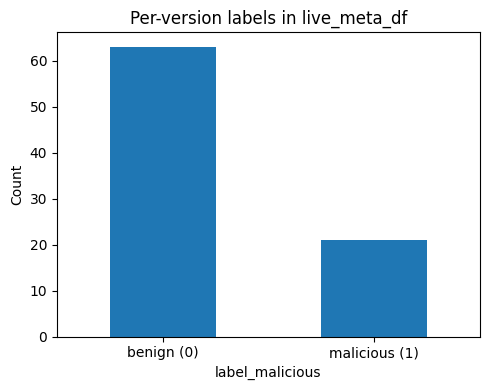

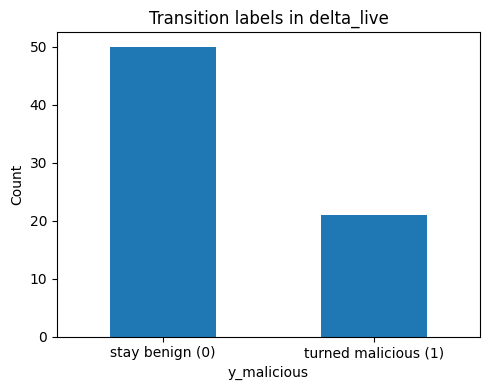

In [12]:
# Cell G1 – Label balance and coverage

import matplotlib.pyplot as plt

# 1) Label balance in live_meta_df (per-version metadata)
label_counts = live_meta_df["label_malicious"].value_counts().sort_index()

plt.figure(figsize=(5, 4))
label_counts.plot(kind="bar")
plt.xticks([0, 1], ["benign (0)", "malicious (1)"], rotation=0)
plt.ylabel("Count")
plt.title("Per-version labels in live_meta_df")
plt.tight_layout()
plt.show()

# 2) Label balance in delta_live (benign→* transitions)
if "delta_live" in globals():
    y_counts = delta_live["y_malicious"].value_counts().sort_index()
    plt.figure(figsize=(5, 4))
    y_counts.plot(kind="bar")
    plt.xticks([0, 1], ["stay benign (0)", "turned malicious (1)"], rotation=0)
    plt.ylabel("Count")
    plt.title("Transition labels in delta_live")
    plt.tight_layout()
    plt.show()
else:
    print("delta_live not found – run the delta-building cells first.")


### Cell G1 – Label balance and coverage

These bar charts are a quick sanity check on how much labeled data we actually have and how imbalanced it is.

- The **first bar chart** shows the label balance in `live_meta_df`: how many package *versions* are tagged as benign vs malicious. We only have 84 versions total, with roughly three times as many benign as malicious (63 benign vs 21 malicious).  
  - This confirms the dataset is small and slightly imbalanced, so any model trained on it should be treated as exploratory rather than production-grade.
- The **second bar chart** shows the label balance in `delta_live` (`y_malicious`): how many **benign→benign** vs **benign→malicious** transitions we found when aligning a malicious version with its previous benign version. There are more “stay benign” transitions than “turn malicious” ones.
  - This tells us that even in the “delta” view we still have class imbalance, but both classes are represented in reasonable numbers.

Overall, G1 answers: **Do we have enough positive and negative examples to run supervised experiments at all, and how imbalanced are they?** The answer is “barely yes, with noticeable but not extreme imbalance.”


Plotting feature distributions for: ['num_dependencies', 'num_dev_dependencies', 'description_len', 'num_scripts']


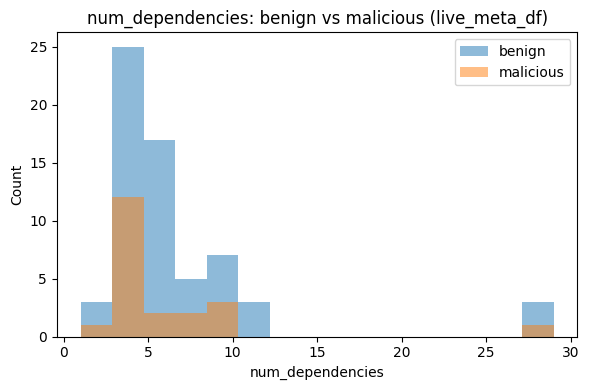

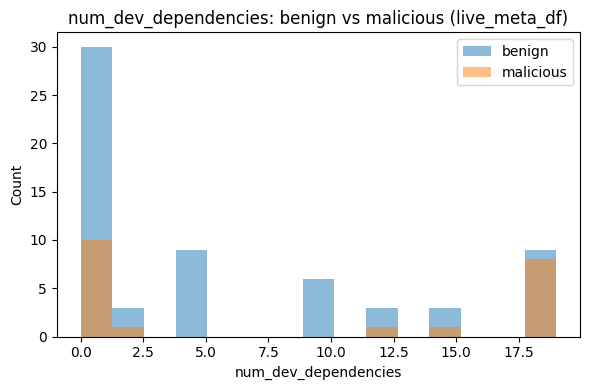

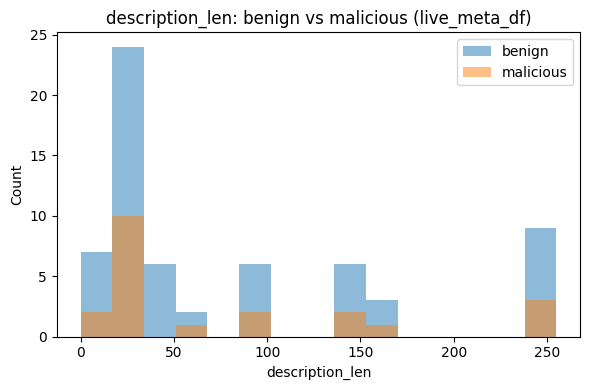

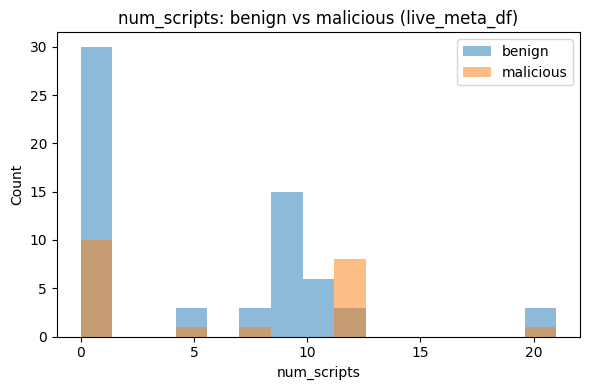

In [13]:
# Cell G2 – Static metadata feature distributions by label

import numpy as np
import matplotlib.pyplot as plt

# Pick a few interesting features (only those actually present)
candidate_features = [
    "num_requires_dist",
    "num_dependencies",
    "num_dev_dependencies",
    "summary_len",
    "description_len",
    "num_scripts",
]
plot_features = [f for f in candidate_features if f in live_meta_df.columns]

print("Plotting feature distributions for:", plot_features)

for feat in plot_features:
    plt.figure(figsize=(6, 4))

    # Benign
    benign_vals = live_meta_df[live_meta_df["label_malicious"] == 0][feat].dropna()
    # Malicious
    mal_vals = live_meta_df[live_meta_df["label_malicious"] == 1][feat].dropna()

    # Choose shared bins
    all_vals = pd.concat([benign_vals, mal_vals])
    if all_vals.empty:
        print(f"Skipping {feat}: no data.")
        plt.close()
        continue

    bins = np.histogram_bin_edges(all_vals, bins=15)

    plt.hist(benign_vals, bins=bins, alpha=0.5, label="benign")
    plt.hist(mal_vals, bins=bins, alpha=0.5, label="malicious")

    plt.xlabel(feat)
    plt.ylabel("Count")
    plt.title(f"{feat}: benign vs malicious (live_meta_df)")
    plt.legend()
    plt.tight_layout()
    plt.show()


### Cell G2 – Static metadata feature distributions by label

These plots compare **simple registry metadata features** between benign and malicious versions in `live_meta_df`.

- For each feature (e.g. `num_dependencies`, `num_dev_dependencies`, `description_len`, `num_scripts`), we plot the **benign** and **malicious** distributions on the same axis (often with a log-scaled x-axis).
- The goal is to eyeball whether malicious versions systematically differ in obvious ways:
  - Do malicious versions tend to have **more or fewer dependencies**?
  - Are their **descriptions shorter or longer**?
  - Are they more likely to define **scripts**?
- Heavy overlap between the curves means “this feature alone is weak as a detector,” while clearly shifted or skewed distributions hint at features that might carry some signal once combined in a model.

In short, G2 provides a **univariate** view of the static metadata and helps decide which features are worth keeping, transforming, or potentially dropping.

---

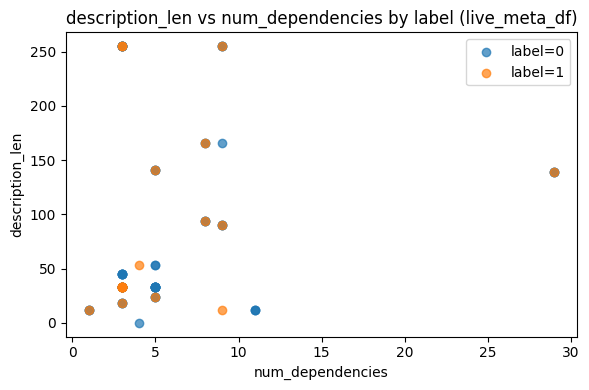

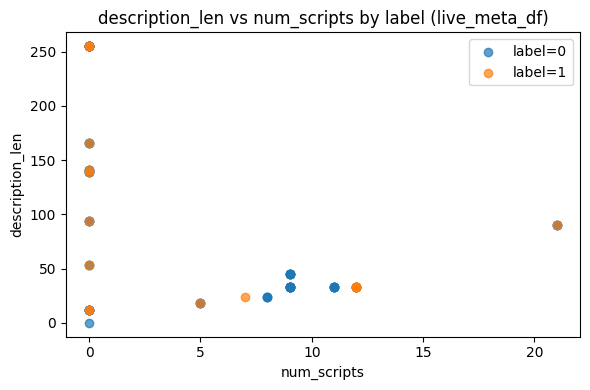

In [14]:
# Cell G3 – Scatter plots for a few feature pairs

import matplotlib.pyplot as plt

pairs = [
    ("num_dependencies", "description_len"),
    ("num_requires_dist", "summary_len"),
    ("num_scripts", "description_len"),
]

for x_feat, y_feat in pairs:
    if x_feat not in live_meta_df.columns or y_feat not in live_meta_df.columns:
        continue

    plt.figure(figsize=(6, 4))

    for label_val in [0, 1]:
        subset = live_meta_df[live_meta_df["label_malicious"] == label_val]
        if subset.empty:
            continue
        plt.scatter(
            subset[x_feat],
            subset[y_feat],
            alpha=0.7,
            label=f"label={label_val}",
        )

    plt.xlabel(x_feat)
    plt.ylabel(y_feat)
    plt.title(f"{y_feat} vs {x_feat} by label (live_meta_df)")
    plt.legend()
    plt.tight_layout()
    plt.show()


### Cell G3 – Pairwise relationships between static features

Cell G3 steps up from 1D histograms to 2D relationships and shows **scatter plots of feature pairs**, coloured by label.

- Each panel plots a pair of features such as:
  - `num_dependencies` vs `description_len`
  - `num_requires_dist` vs `summary_len`
  - `num_scripts` vs `description_len`
- Points are coloured by `label_malicious`, so we can see whether malicious versions form any **distinct clusters** or occupy particular regions of feature space (for example, “few dependencies but very long descriptions,” or “many dependencies plus non-empty scripts”).
- With such a small dataset, we don’t expect perfectly separated clusters, but we *do* want to check:
  - Are there obvious outliers that might be labelling or parsing errors?
  - Do any simple visual rules pop out (“all malicious points fall into this corner”)?

G3 is mainly about **intuition and anomaly-hunting**: it helps confirm that our feature engineering looks sensible and that any downstream model is not being driven by a handful of pathological points.

---

Plotting delta feature distributions for: ['delta_num_requires_dist', 'delta_num_dependencies', 'delta_num_dev_dependencies', 'delta_summary_len', 'delta_description_len', 'delta_num_scripts']


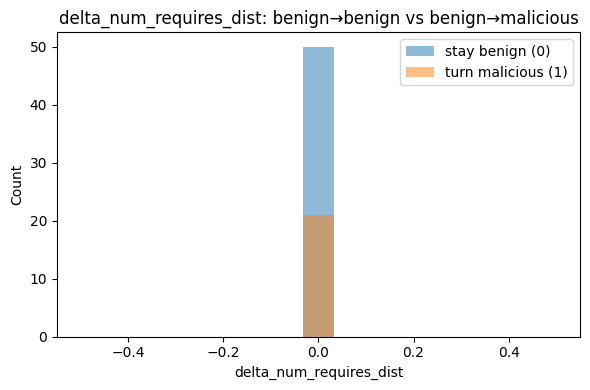

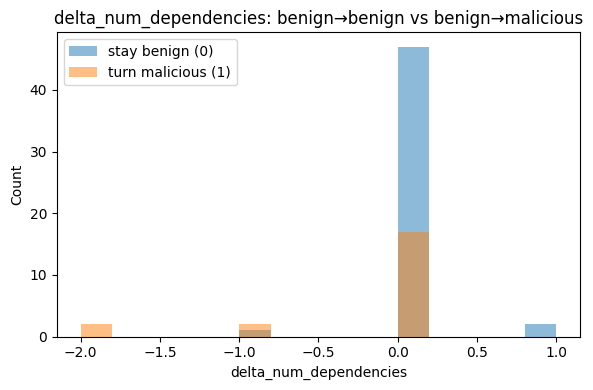

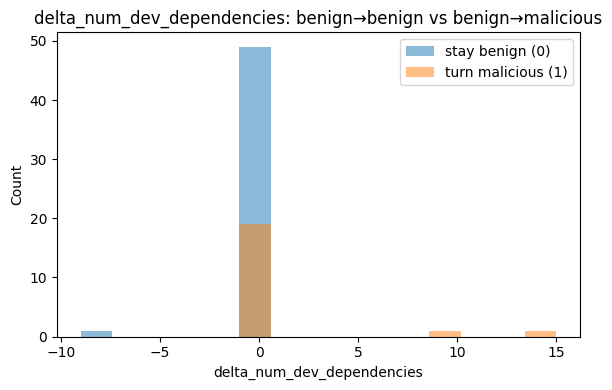

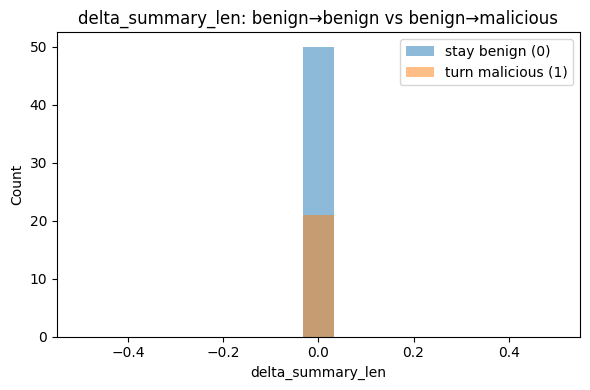

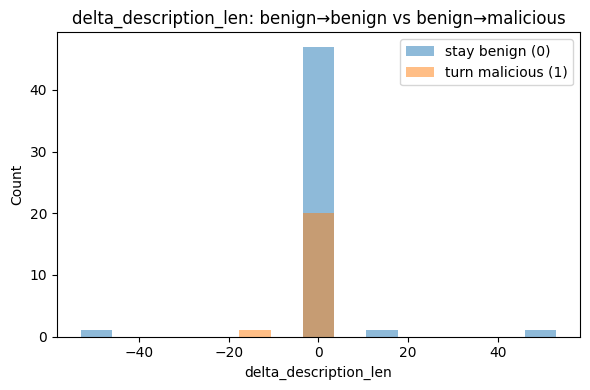

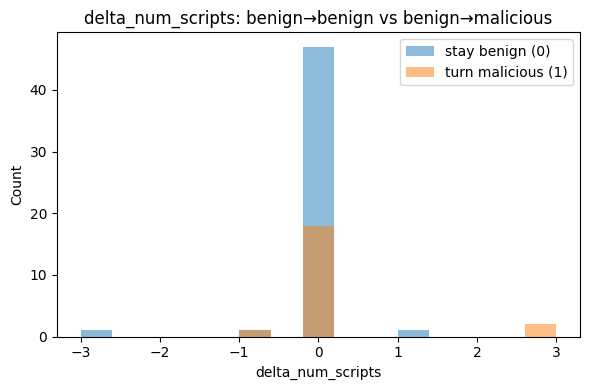

In [15]:
# Cell G4 – Delta feature distributions for benign→* transitions

import numpy as np
import matplotlib.pyplot as plt

if "delta_live" not in globals():
    print("delta_live not found – run the delta-building cells first.")
else:
    # Pick a few delta features to visualize
    candidate_delta_feats = [
        "delta_num_requires_dist",
        "delta_num_dependencies",
        "delta_num_dev_dependencies",
        "delta_summary_len",
        "delta_description_len",
        "delta_num_scripts",
    ]
    plot_delta_feats = [d for d in candidate_delta_feats if d in delta_live.columns]

    print("Plotting delta feature distributions for:", plot_delta_feats)

    for dfeat in plot_delta_feats:
        plt.figure(figsize=(6, 4))

        benign_trans = delta_live[delta_live["y_malicious"] == 0][dfeat].dropna()
        mal_trans = delta_live[delta_live["y_malicious"] == 1][dfeat].dropna()

        all_vals = pd.concat([benign_trans, mal_trans])
        if all_vals.empty:
            print(f"Skipping {dfeat}: no data.")
            plt.close()
            continue

        bins = np.histogram_bin_edges(all_vals, bins=15)

        plt.hist(benign_trans, bins=bins, alpha=0.5, label="stay benign (0)")
        plt.hist(mal_trans, bins=bins, alpha=0.5, label="turn malicious (1)")

        plt.xlabel(dfeat)
        plt.ylabel("Count")
        plt.title(f"{dfeat}: benign→benign vs benign→malicious")
        plt.legend()
        plt.tight_layout()
        plt.show()


### Cell G4 – Delta feature distributions for benign→* transitions

G4 repeats the idea from G2, but now on **delta features** derived from version differences (`delta_live`), where each row represents a transition from a previously benign version.

- For each `delta_*` feature (e.g. `delta_num_dependencies`, `delta_num_dev_dependencies`, `delta_summary_len`, `delta_description_len`, `delta_num_scripts`), we plot two distributions:
  - **“stay benign (0)”** – benign→benign transitions  
  - **“turn malicious (1)”** – benign→malicious transitions
- The x-axis is the *change* in that feature between the previous benign version and the current one. Values near zero mean “this field hardly changed across versions.”
- Conceptually, these plots check whether **malicious transitions “move” differently** than benign ones:
  - Do malicious upgrades tend to **add more dependencies** or **introduce scripts**?
  - Do they show larger swings in **description or summary length**?

G4 is the visual answer to: **“Does watching how metadata changes between versions add useful signal about maliciousness, beyond just looking at a single snapshot?”** It sets the stage for the simple delta-based classifier that follows.

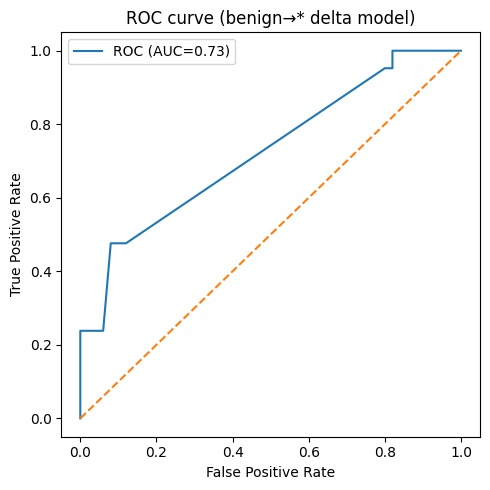

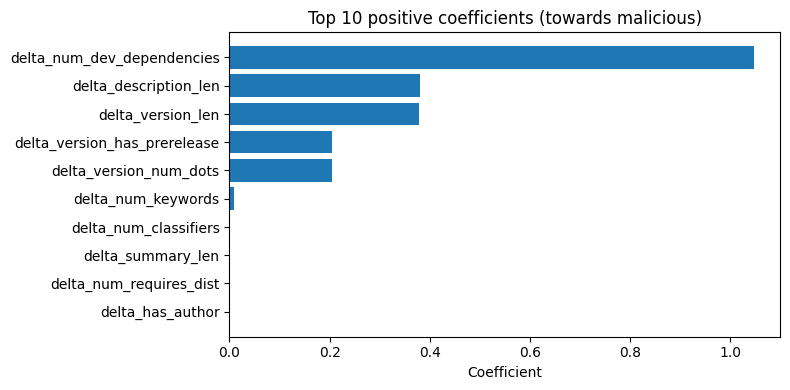

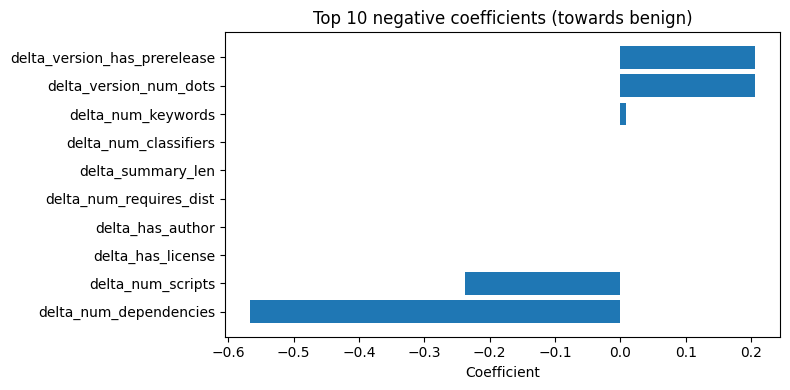

In [16]:
# Cell G5 – Model ROC curve and feature importance (if model exists)

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

if "model" not in globals():
    print("No trained model found. Train the logistic regression pipeline first.")
else:
    X = delta_live[delta_cols].fillna(0.0).astype(float)
    y = delta_live["y_malicious"].astype(int)

    if y.nunique() < 2:
        print("Only one class present in delta_live – ROC/importance not meaningful.")
    else:
        # Pred proba on full dataset (or reuse X_test / y_test if you kept them)
        y_proba = model.predict_proba(X)[:, 1]
        fpr, tpr, _ = roc_curve(y, y_proba)
        auc = roc_auc_score(y, y_proba)

        # ROC curve
        plt.figure(figsize=(5, 5))
        plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.2f})")
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC curve (benign→* delta model)")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Feature importance from logistic regression coefficients
        lr = model.named_steps["logisticregression"]
        coef_df = pd.DataFrame({
            "feature": delta_cols,
            "coef": lr.coef_[0],
        }).sort_values("coef", ascending=False)

        top_k = 10
        top_pos = coef_df.head(top_k)
        top_neg = coef_df.tail(top_k)

        # Positive coefficients: deltas that push towards "malicious"
        plt.figure(figsize=(8, 4))
        plt.barh(top_pos["feature"], top_pos["coef"])
        plt.xlabel("Coefficient")
        plt.title(f"Top {top_k} positive coefficients (towards malicious)")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

        # Negative coefficients: deltas that push towards "benign"
        plt.figure(figsize=(8, 4))
        plt.barh(top_neg["feature"], top_neg["coef"])
        plt.xlabel("Coefficient")
        plt.title(f"Top {top_k} negative coefficients (towards benign)")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()


### Cell G5 – Model ROC curve and feature importance

#### ROC curve

The first plot is the **Receiver Operating Characteristic (ROC) curve** for the current model:

- The x-axis is the **False Positive Rate (FPR)**: proportion of benign samples incorrectly flagged as malicious.
- The y-axis is the **True Positive Rate (TPR)**: proportion of malicious samples correctly detected.
- The dashed diagonal line is the **random baseline** (a model that guesses malicious vs benign at random).
- The solid curve shows how the model behaves as we sweep the decision threshold from “very strict” to “very loose,” and the legend reports the **Area Under the Curve (AUC)**.

Interpretation:

- If the ROC curve lies substantially **above the diagonal**, the model is doing **better than random** at ranking malicious higher than benign.
- The **AUC** summarizes this into a single number in \[0.5, 1.0\]:  
  - ~0.5 ≈ random guessing  
  - closer to 1.0 ≈ strong separation
- In this notebook we’re plotting ROC on the **same data used to fit the model**, so this is mainly a **sanity check** that the model learned *some* signal. A proper evaluation would use a held-out test set or cross-validation.


---

#### Feature importance (logistic regression coefficients)

The next two bar charts use the **logistic regression coefficients** as a proxy for feature importance.

Since the model is linear and we’ve standardised the input features:

- Each `delta_*` feature gets a **coefficient**.
- A **positive coefficient** means “increasing this feature pushes the prediction towards *malicious*.”
- A **negative coefficient** means “increasing this feature pushes the prediction towards *benign*.”

The notebook visualises:

1. **Top positive coefficients (“towards malicious”)**  
   - These are the delta features whose increase is most associated with the malicious label.  
   - For example, a strongly positive coefficient on something like `delta_num_dependencies` would mean that versions which **suddenly gain dependencies** compared to their previous benign version are more suspicious.

2. **Top negative coefficients (“towards benign”)**  
   - These are delta features whose increase is most associated with *staying benign*.  
   - For example, a strong negative coefficient on a “delta” feature would suggest that that type of change is characteristic of normal evolution rather than an attack.

Reading these plots:

- Look at **which `delta_*` fields show up near the top** of each bar chart; those are the features the model leans on most heavily.
- Remember that coefficients capture **direction and relative strength**, not causal truth:
  - Correlated features can share credit or blame.
  - With so few samples, some coefficients may be unstable or noisy.

Overall, G5 answers two questions:

1. **Does the current model behave sensibly at all, compared to random guessing?** (ROC / AUC)
2. **Which *changes in metadata* are the strongest directional signals of a version turning malicious vs staying benign?** (positive vs negative coefficients)
